# Modelo DNN

In [1]:
import pandas as pd
import numpy as np
import torch, time
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn import metrics
import os, random

In [2]:
SEED = 42
# Carga dataset desde la carpeta raíz generada por TINTOlib
ruta_carpeta_actual = os.getcwd()
ruta_carpeta_raiz = os.path.dirname(ruta_carpeta_actual)
csv_path  = os.path.join(ruta_carpeta_raiz, "dataset", "PuntosMuestra_CR_2023.csv")
df = pd.read_csv(csv_path)

## Limpieza

In [3]:
# Quitar valores de la CATEGORIA = 2
df_filtrado = df[df["CATEGORIA"] != 2].copy()

# Re-mapear las clases a valores consecutivos desde 0
clases_unicas = sorted(df_filtrado["CATEGORIA"].unique())
mapa = {old: new for new, old in enumerate(clases_unicas)}
df_filtrado["CATEGORIA"] = df_filtrado["CATEGORIA"].map(mapa)

y = df_filtrado["CATEGORIA"]
X = df_filtrado.drop(columns=["CATEGORIA","lon","lat","year"])

## Preprocesamiento

In [4]:
# Estandarizar características (mejora el entrenamiento de redes)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Data de entrenamiento y prueba

In [5]:
# --------------------------
# 2. Split train/test
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Asegura tipos
y_train_np = np.asarray(y_train, dtype=np.int64)
y_test_np  = np.asarray(y_test,  dtype=np.int64)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train_np, dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test_np,  dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

## Definir modelo entrenamiento

In [6]:
def seed_worker(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)

g = torch.Generator().manual_seed(SEED)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,
                      generator=g, worker_init_fn=seed_worker)
test_dl  = DataLoader(test_ds,  batch_size=128, shuffle=False,
                      generator=g, worker_init_fn=seed_worker)

# ===== 3) Modelo MLP =====
import torch.nn as nn

input_dim = X_train.shape[1]
num_classes = int(pd.Series(y).nunique())  # o len(np.unique(y))

class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
        )
    def forward(self, x): return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim, num_classes).to(device)

crit = nn.CrossEntropyLoss()
opt  = torch.optim.Adam(model.parameters(), lr=1e-3)

## Entrenamiento y testeo

In [7]:
EPOCHS = 100
t0 = time.perf_counter()
for ep in range(EPOCHS):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        opt.step()
fit_s = time.perf_counter() - t0
print(f"⏱ Entrenamiento ({EPOCHS} ep): {fit_s:.2f}s")

# ===== 5) Test cronometrado + métricas =====
t0 = time.perf_counter()
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu().tolist()
        y_pred += preds
        y_true += yb.tolist()
pred_s = time.perf_counter() - t0
ms_per_sample = (pred_s/len(y_true))*1000


⏱ Entrenamiento (100 ep): 31.59s


## Resultados

In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix, classification_report

oa = accuracy_score(y_true, y_pred)
prec, rec, f1m, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
cm  = confusion_matrix(y_true, y_pred)
cm_row_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
cm_row_percentage = np.nan_to_num(cm_row_percentage)  # handle division by zero

print(f"⏱ Test: {pred_s:.3f}s  ({ms_per_sample:.2f} ms/muestra)")
print(f"OA: {oa:.4f} | Prec(macro): {prec:.4f} | Recall(macro): {rec:.4f} | F1-macro: {f1m:.4f}")
print("Matriz de confusión:\n", cm)

⏱ Test: 0.042s  (0.00 ms/muestra)
OA: 0.8913 | Prec(macro): 0.8442 | Recall(macro): 0.8185 | F1-macro: 0.8305
Matriz de confusión:
 [[2249  193    1    2    9    5]
 [ 167 4286    2   10   21   82]
 [   5    3  318   10    0    0]
 [   3   13    7  291   16   24]
 [  20   39    0   20  282   51]
 [  28  151    0   24   46  382]]


### Matriz de confusion

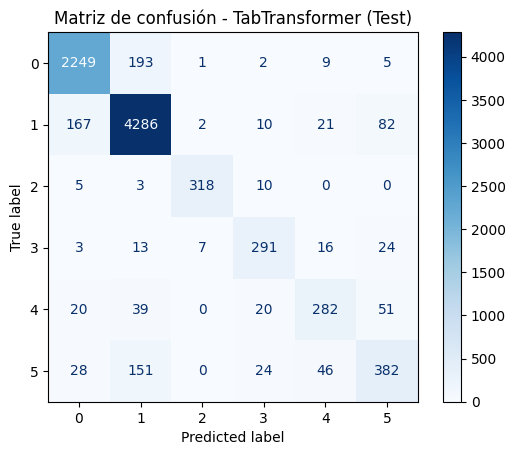

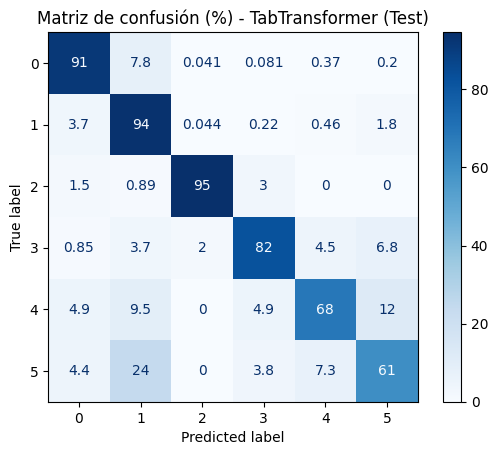

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Matriz de confusión - TabTransformer (Test)")
plt.show()

ConfusionMatrixDisplay(cm_row_percentage).plot(cmap='Blues')
plt.title("Matriz de confusión (%) - TabTransformer (Test)")
plt.show()

# Registrar informacion